# LightGBM Classification Project

## Heart Disease Prediction using LightGBM

This notebook demonstrates a complete machine learning pipeline using **LightGBM (Light Gradient Boosting Machine)**, one of the most powerful and efficient gradient boosting frameworks.

### What is LightGBM?

LightGBM is a gradient boosting framework developed by Microsoft that uses tree-based learning algorithms. It's designed for:
- **Speed**: Significantly faster training than traditional GBDT
- **Efficiency**: Lower memory usage
- **Accuracy**: High performance on various datasets
- **Large datasets**: Optimized for datasets with millions of instances

### Key Features:
1. **Leaf-wise tree growth**: Grows trees by selecting leaves with maximum delta loss (vs level-wise)
2. **Histogram-based algorithm**: Buckets continuous features into discrete bins
3. **Gradient-based One-Side Sampling (GOSS)**: Keeps instances with large gradients
4. **Exclusive Feature Bundling (EFB)**: Bundles mutually exclusive features


## 1. Import Required Libraries

First, we import all necessary libraries for data manipulation, visualization, modeling, and evaluation.

In [133]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning - LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    log_loss, matthews_corrcoef
)

# Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

# Utilities
import warnings

# Settings
warnings.filterwarnings('ignore')
np.random.seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"LightGBM version: {lgb.__version__}")

LightGBM version: 4.6.0


## 2. Load and Explore the Dataset

**Dataset**: Heart Disease Dataset
- **Source**: UCI Machine Learning Repository
- **Objective**: Predict heart disease presence (binary classification)
- **Features**: 11 clinical features including age, sex, chest pain type, blood pressure, cholesterol, etc.

In [134]:
# Load the dataset
data_path = '../datasets/heart.csv'
df = pd.read_csv(data_path)

# Initial Data Exploration
print("="*80)
print("Dataset Overview")
print("="*80)
print(f"\nDataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nFirst few rows:")
print(df.head(10))

print("\n" + "="*80)
print("Basic Information")
print("="*80)
print(df.info())

print("\n" + "="*80)
print("Statistical Summary")
print("="*80)
print(df.describe().round(2))

print("\n" + "="*80)
print("Target Variable Distribution")
print("="*80)
target_counts = df['HeartDisease'].value_counts()
print(f"\n{target_counts}")
print(f"\nClass Balance:")
print(f"  - No Disease (0): {target_counts[0]} ({target_counts[0]/len(df)*100:.2f}%)")
print(f"  - Disease (1): {target_counts[1]} ({target_counts[1]/len(df)*100:.2f}%)")

print("\n" + "="*80)
print("Missing Values Check")
print("="*80)
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values found!")

Dataset Overview

Dataset shape: 918 rows × 12 columns

First few rows:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   
5   39   M           NAP        120          339          0     Normal    170   
6   45   F           ATA        130          237          0     Normal    170   
7   54   M           ATA        110          208          0     Normal    142   
8   37   M           ASY        140          207          0     Normal    130   
9   48   F           ATA        120          284          0     Normal    120   

  ExerciseAngina  Oldpeak ST_Slope  

### 2.1 Data Visualization

Visualize the distribution of features and their relationship with the target variable.

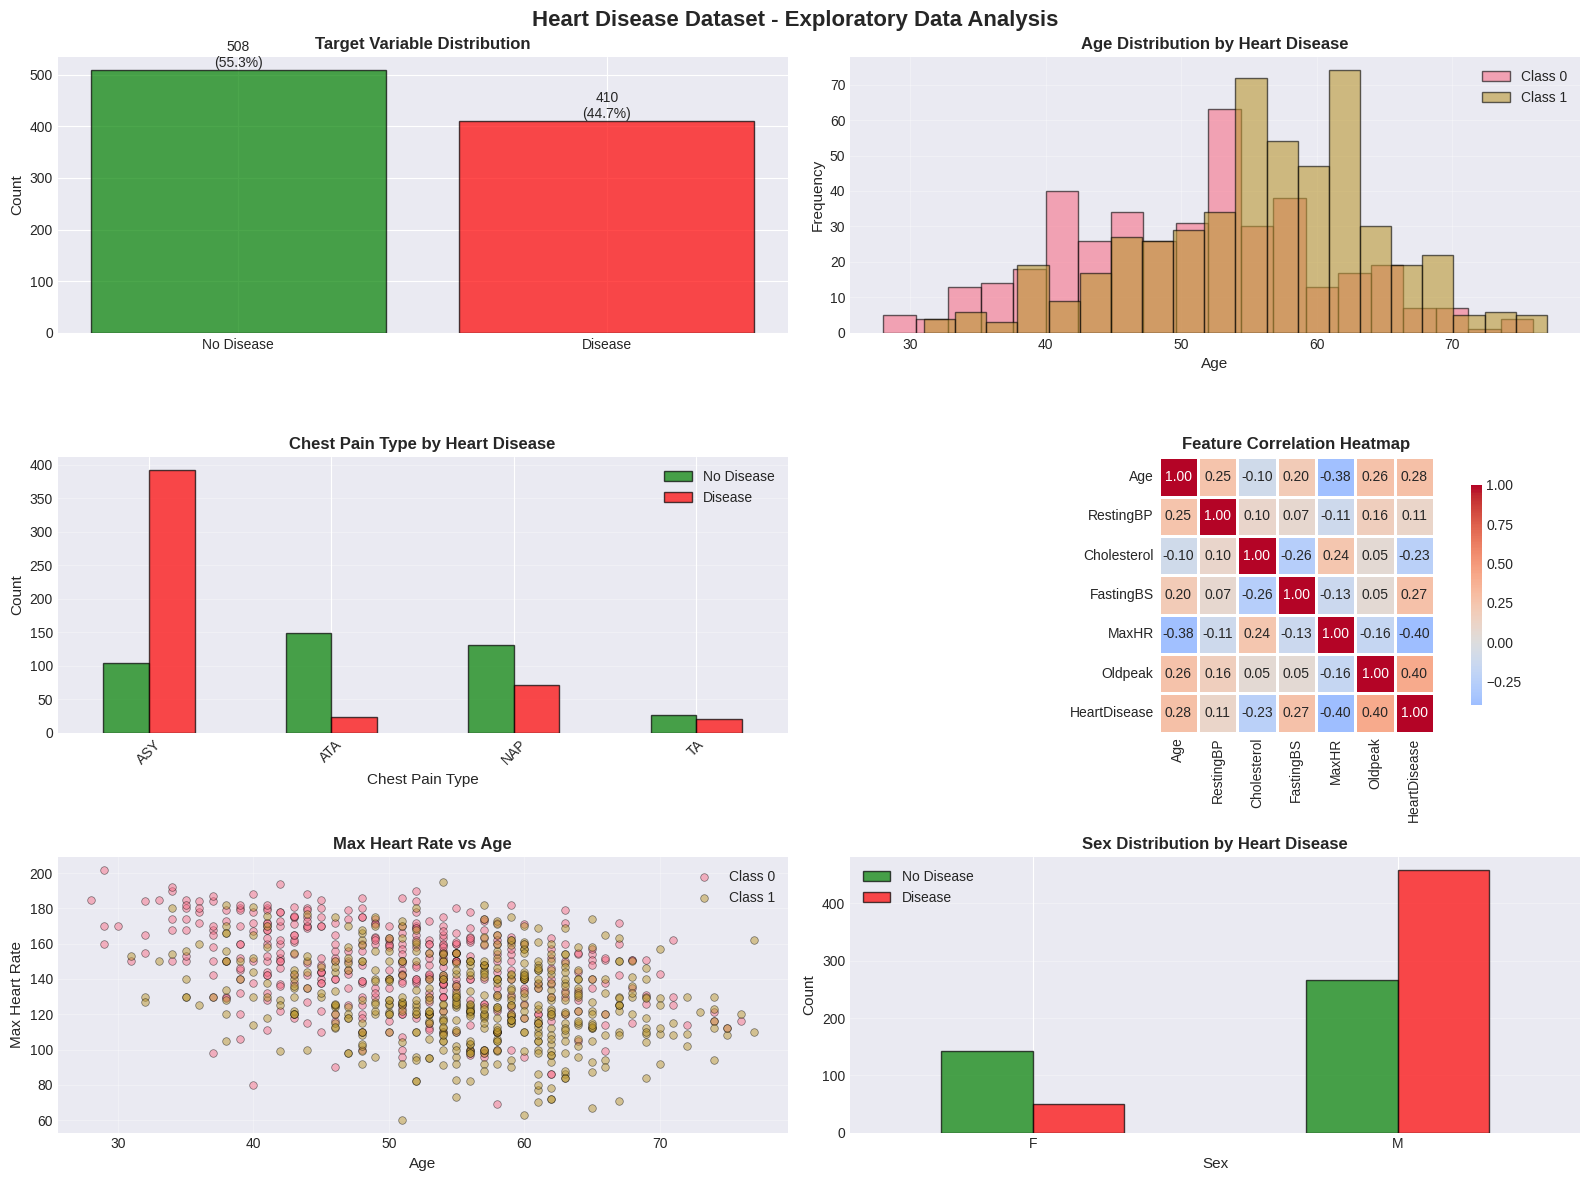


Visualizations completed!


In [135]:
# Create comprehensive visualizations
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Heart Disease Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Target Distribution
ax1 = axes[0, 0]
target_counts = df['HeartDisease'].value_counts()
colors = ['green', 'red']
bars = ax1.bar(['No Disease', 'Disease'], target_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Target Variable Distribution', fontsize=12, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({height/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontsize=10)

# 2. Age Distribution by Target
ax2 = axes[0, 1]
for target in [0, 1]:
    subset = df[df['HeartDisease'] == target]['Age']
    ax2.hist(subset, bins=20, alpha=0.6, label=f'Class {target}', edgecolor='black')
ax2.set_xlabel('Age', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Age Distribution by Heart Disease', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Chest Pain Type Distribution
ax3 = axes[1, 0]
chest_pain_counts = df.groupby(['ChestPainType', 'HeartDisease']).size().unstack()
chest_pain_counts.plot(kind='bar', ax=ax3, color=['green', 'red'], alpha=0.7, edgecolor='black')
ax3.set_xlabel('Chest Pain Type', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('Chest Pain Type by Heart Disease', fontsize=12, fontweight='bold')
ax3.legend(['No Disease', 'Disease'])
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Correlation Heatmap (numerical features only)
ax4 = axes[1, 1]
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, ax=ax4, cbar_kws={"shrink": 0.8})
ax4.set_title('Feature Correlation Heatmap', fontsize=12, fontweight='bold')

# 5. MaxHR vs Age
ax5 = axes[2, 0]
for heart_disease in [0, 1]:
    subset = df[df['HeartDisease'] == heart_disease]
    ax5.scatter(subset['Age'], subset['MaxHR'], alpha=0.5, s=30,
                label=f'Class {heart_disease}', edgecolors='black', linewidth=0.5)
ax5.set_xlabel('Age', fontsize=11)
ax5.set_ylabel('Max Heart Rate', fontsize=11)
ax5.set_title('Max Heart Rate vs Age', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Sex Distribution
ax6 = axes[2, 1]
sex_counts = df.groupby(['Sex', 'HeartDisease']).size().unstack()
sex_counts.plot(kind='bar', ax=ax6, color=['green', 'red'], alpha=0.7, edgecolor='black')
ax6.set_xlabel('Sex', fontsize=11)
ax6.set_ylabel('Count', fontsize=11)
ax6.set_title('Sex Distribution by Heart Disease', fontsize=12, fontweight='bold')
ax6.legend(['No Disease', 'Disease'])
ax6.tick_params(axis='x', rotation=0)
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nVisualizations completed!")

## 3. Data Preprocessing with Pipeline

**Why Use Pipeline?**
- **Reproducibility**: Ensures same transformations in train/test/production
- **Prevention of Data Leakage**: Fit only on training data
- **Cleaner Code**: Encapsulates all preprocessing steps
- **Easy Deployment**: Save entire pipeline as single object

**Pipeline Steps:**
1. Handle invalid values (zeros in critical features)
2. Encode categorical variables (label + one-hot encoding)
3. Scale numerical features
4. Train model

**Note**: We'll create a custom transformer for handling zeros and use ColumnTransformer for different feature types.

In [136]:
print("Building preprocessing pipeline...")

# Prepare the raw data
df_clean = df.copy()

# Identify feature types
binary_categorical = ['Sex', 'ExerciseAngina']
multi_categorical = ['ChestPainType', 'RestingECG', 'ST_Slope']
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

print(f"\nFeature types identified:")
print(f"  - Binary categorical ({len(binary_categorical)}): {binary_categorical}")
print(f"  - Multi-class categorical ({len(multi_categorical)}): {multi_categorical}")
print(f"  - Numerical ({len(numerical_features)}): {numerical_features}")

# Function to impute zero values with median
def impute_zeros(X):
    X_copy = X.copy()
    for col in ['Cholesterol', 'RestingBP']:
        if col in X_copy.columns:
            non_zero_values = X_copy[col][X_copy[col] > 0]
            median_val = non_zero_values.median()
            X_copy.loc[X_copy[col] == 0, col] = median_val
    return X_copy

# Function to encode binary categorical variables
def encode_binary(X):
    X_copy = X.copy()
    for col in X_copy.columns:
        le = LabelEncoder()
        X_copy[col] = le.fit_transform(X_copy[col])
    return X_copy

# Create preprocessing pipeline using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('binary_cat', Pipeline([
            ('encoder', FunctionTransformer(encode_binary))
        ]), binary_categorical),
        
        ('multi_cat', Pipeline([
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
        ]), multi_categorical),
        
        ('num', Pipeline([
            ('imputer', FunctionTransformer(impute_zeros)),
            ('scaler', StandardScaler())
        ]), numerical_features)
    ],
    remainder='passthrough'
)

Building preprocessing pipeline...

Feature types identified:
  - Binary categorical (2): ['Sex', 'ExerciseAngina']
  - Multi-class categorical (3): ['ChestPainType', 'RestingECG', 'ST_Slope']
  - Numerical (6): ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']


## 4. Train-Test Split & Validation Strategy

**Strategy**: 
- Use **stratified split** to maintain class distribution
- Split ratio: 80% training, 20% testing
- Further split training into train/validation for hyperparameter tuning
- Use **Stratified K-Fold Cross-Validation** for robust evaluation

In [137]:
# Separate features and target from ORIGINAL data (before manual preprocessing)
X = df_clean.drop('HeartDisease', axis=1)
y = df_clean['HeartDisease']

print("="*80)
print("TRAIN-TEST SPLIT")
print("="*80)
print(f"\nOriginal data (before preprocessing):")
print(f"  Feature matrix shape: {X.shape}")
print(f"  Target vector shape: {y.shape}")

# Split into train and test sets (80-20 split, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\n Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f" Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Check class distribution
print("\n" + "-"*80)
print("Class Distribution (Stratified)")
print("-"*80)
train_dist = y_train.value_counts(normalize=True) * 100
test_dist = y_test.value_counts(normalize=True) * 100

print(f"\nTraining set:")
print(f"  No Disease (0): {(y_train == 0).sum()} ({train_dist[0]:.1f}%)")
print(f"  Disease (1): {(y_train == 1).sum()} ({train_dist[1]:.1f}%)")

print(f"\nTest set:")
print(f"  No Disease (0): {(y_test == 0).sum()} ({test_dist[0]:.1f}%)")
print(f"  Disease (1): {(y_test == 1).sum()} ({test_dist[1]:.1f}%)")

print("\n Class distribution maintained across splits")

# Setup cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(f"\n Cross-validation: 5-Fold Stratified K-Fold")

TRAIN-TEST SPLIT

Original data (before preprocessing):
  Feature matrix shape: (918, 11)
  Target vector shape: (918,)

 Train set: 734 samples (80.0%)
 Test set: 184 samples (20.0%)

--------------------------------------------------------------------------------
Class Distribution (Stratified)
--------------------------------------------------------------------------------

Training set:
  No Disease (0): 328 (44.7%)
  Disease (1): 406 (55.3%)

Test set:
  No Disease (0): 82 (44.6%)
  Disease (1): 102 (55.4%)

 Class distribution maintained across splits

 Cross-validation: 5-Fold Stratified K-Fold


## 5. Baseline LightGBM Model with Pipeline

Create a complete Pipeline combining preprocessing and model training. This ensures:
- **No data leakage**: Preprocessing fit only on training data
- **Consistency**: Same transformations applied to train/test/production
- **Simplicity**: One object handles everything
- **Deployment-ready**: Save pipeline, not separate components

### Pipeline Structure:
```
Pipeline([
    ('preprocessor', ColumnTransformer(...)),
    ('classifier', LGBMClassifier(...))
])
```

### LightGBM Key Parameters:
- **n_estimators**: Number of boosting rounds (trees)
- **learning_rate**: Step size shrinkage to prevent overfitting
- **max_depth**: Maximum tree depth
- **num_leaves**: Maximum number of leaves in one tree
- **random_state**: For reproducibility

Baseline LightGBM Pipeline

Baseline Model Performance

Metric               Score     
------------------------------
Accuracy             0.8424
Precision            0.8842
Recall               0.8235
F1-Score             0.8528
ROC-AUC              0.9067
Matthews Corr Coef   0.6857

--------------------------------------------------------------------------------
Classification Report
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

  No Disease       0.80      0.87      0.83        82
     Disease       0.88      0.82      0.85       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.85      0.84      0.84       184


--------------------------------------------------------------------------------
Confusion Matrix
--------------------------------------------------------------------------------
[[71 11]
 [18 84]]

-

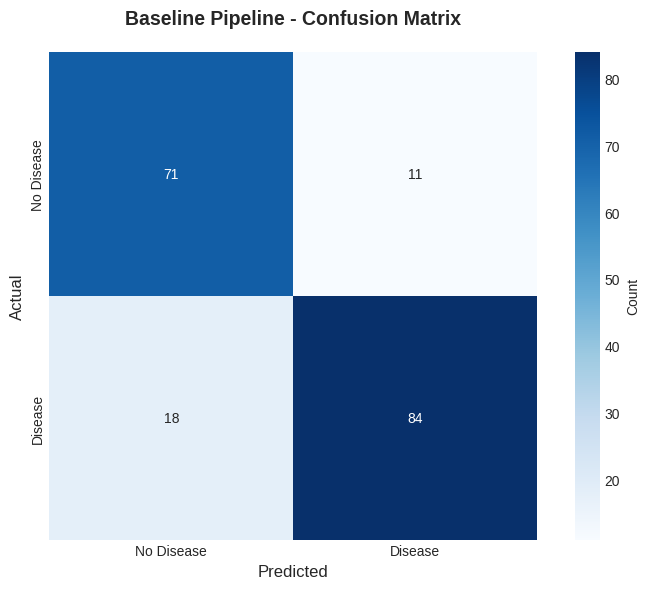

In [138]:
print("Baseline LightGBM Pipeline")


# Create complete pipeline with preprocessing + model
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        verbose=-1
    ))
])

# Train the model
baseline_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_baseline = baseline_pipeline.predict(X_test)
y_pred_proba_baseline = baseline_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\n" + "="*80)
print("Baseline Model Performance")
print("="*80)

accuracy = accuracy_score(y_test, y_pred_baseline)
precision = precision_score(y_test, y_pred_baseline)
recall = recall_score(y_test, y_pred_baseline)
f1 = f1_score(y_test, y_pred_baseline)
roc_auc = roc_auc_score(y_test, y_pred_proba_baseline)
mcc = matthews_corrcoef(y_test, y_pred_baseline)

print(f"\n{'Metric':<20} {'Score':<10}")
print("-"*30)
print(f"{'Accuracy':<20} {accuracy:.4f}")
print(f"{'Precision':<20} {precision:.4f}")
print(f"{'Recall':<20} {recall:.4f}")
print(f"{'F1-Score':<20} {f1:.4f}")
print(f"{'ROC-AUC':<20} {roc_auc:.4f}")
print(f"{'Matthews Corr Coef':<20} {mcc:.4f}")

# Classification Report
print("\n" + "-"*80)
print("Classification Report")
print("-"*80)
print(classification_report(y_test, y_pred_baseline, target_names=['No Disease', 'Disease']))

# Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print("\n" + "-"*80)
print("Confusion Matrix")
print("-"*80)
print(cm_baseline)

# Cross-validation score (on training data)
print("\n" + "-"*80)
print("Cross-Validation Performance")
print("-"*80)
cv_scores = cross_val_score(baseline_pipeline, X_train, y_train, 
                            cv=cv_strategy, scoring='roc_auc', n_jobs=-1)
print(f"ROC-AUC CV Scores: {cv_scores}")
print(f"Mean ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualize confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'],
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_ylabel('Actual', fontsize=12)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_title('Baseline Pipeline - Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 6. Baseline Model Feature Importance

Analyze which features are most important for the baseline model before adding engineered features.

Baseline model feature importance analysis...

All feature importances (baseline model):
          Feature  Importance
            MaxHR         565
      Cholesterol         526
              Age         439
        RestingBP         374
          Oldpeak         358
              Sex          95
ChestPainType_NAP          80
RestingECG_Normal          78
   ExerciseAngina          77
    ST_Slope_Flat          69
      ST_Slope_Up          64
        FastingBS          53
ChestPainType_ATA          42
 ChestPainType_TA          26
    RestingECG_ST          23


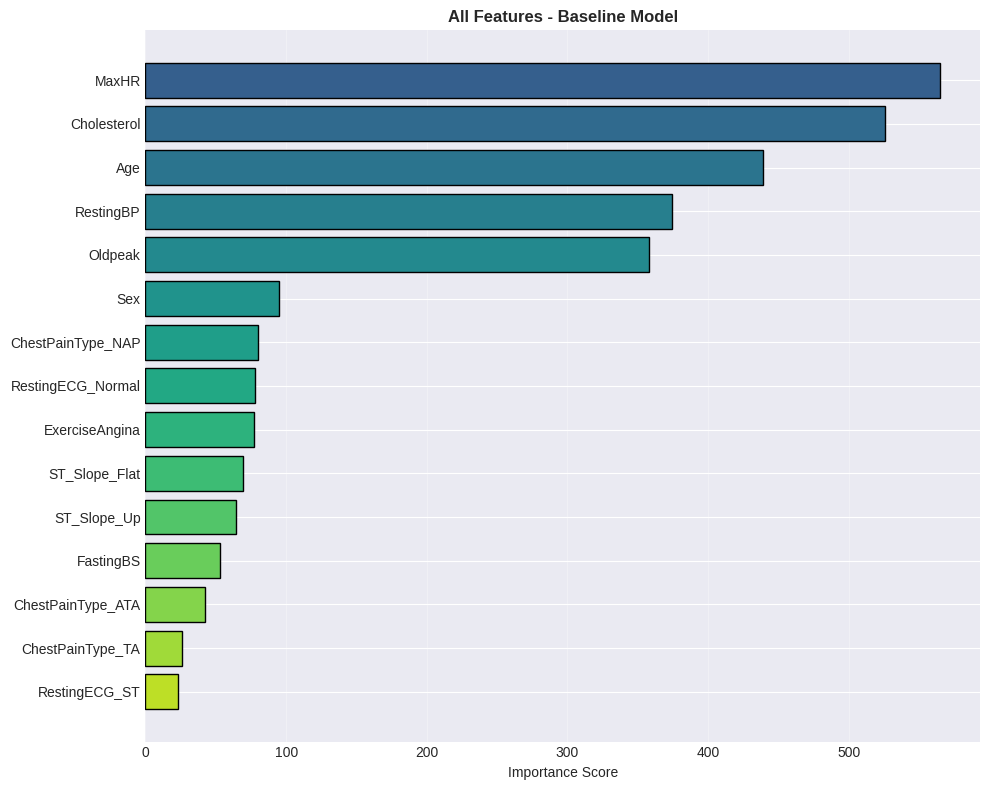


✓ Baseline feature importance analysis complete


In [ ]:
print("Baseline model feature importance analysis...")

# Extract classifier from baseline pipeline
lgb_baseline_classifier = baseline_pipeline.named_steps['classifier']

# Get feature names after preprocessing
preprocessor_baseline = baseline_pipeline.named_steps['preprocessor']

# Build feature names
baseline_feature_names = []
baseline_feature_names.extend(binary_categorical)
onehot_baseline = preprocessor_baseline.named_transformers_['multi_cat'].named_steps['onehot']
onehot_baseline_names = onehot_baseline.get_feature_names_out(multi_categorical)
baseline_feature_names.extend(onehot_baseline_names)
baseline_feature_names.extend(numerical_features)

# Get feature importance
baseline_feature_importance = pd.DataFrame({
    'Feature': baseline_feature_names,
    'Importance': lgb_baseline_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nAll feature importances (baseline model):")
print(baseline_feature_importance.to_string(index=False))

# Visualize all features
fig, ax = plt.subplots(1, 1, figsize=(10, max(8, len(baseline_feature_importance) * 0.4)))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(baseline_feature_importance)))
ax.barh(range(len(baseline_feature_importance)), baseline_feature_importance['Importance'], color=colors, edgecolor='black')
ax.set_yticks(range(len(baseline_feature_importance)))
ax.set_yticklabels(baseline_feature_importance['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance Score')
ax.set_title('All Features - Baseline Model', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n Baseline feature importance analysis complete")

## 7. Feature Engineering

Create new features based on domain knowledge to improve model performance. These engineered features will be used for hyperparameter tuning and the optimized model.

In [ ]:
print("Creating engineered features...")

# Function to create new features
def create_engineered_features(X):
    """Create new features based on cardiovascular domain knowledge"""
    X_new = X.copy()
    
    # Heart rate metrics
    expected_max_hr = 220 - X['Age']
    X_new['hr_reserve'] = X['MaxHR'] - expected_max_hr
    X_new['hr_percentage'] = (X['MaxHR'] / expected_max_hr) * 100
    X_new['hr_deficit'] = expected_max_hr - X['MaxHR']
    
    
    # Risk interactions
    X_new['oldpeak_age_interaction'] = X['Oldpeak'] * X['Age']
    X_new['age_chol_interaction'] = X['Age'] * X['Cholesterol'] / 1000
    
    
    # Combined features
    X_new['pain_exercise_combo'] = X['ChestPainType'].astype(str) + '_' + X['ExerciseAngina'].astype(str)
    
    return X_new

# Apply to both train and test sets
X_train_eng = create_engineered_features(X_train)
X_test_eng = create_engineered_features(X_test)

# Also update the main dataset for future use
df = create_engineered_features(df)

print(f"\nOriginal features: {X_train.shape[1]}")
print(f"Engineered features: {X_train_eng.shape[1]}")
print(f"New features added: {X_train_eng.shape[1] - X_train.shape[1]}")

# Show new features
new_features = set(X_train_eng.columns) - set(X_train.columns)
print(f"\nEngineered features:")
for feat in sorted(new_features):
    print(f"  • {feat}")

print("\n Feature engineering complete")

Creating engineered features...

Original features: 11
Engineered features: 17
New features added: 6

Engineered features:
  • age_chol_interaction
  • hr_deficit
  • hr_percentage
  • hr_reserve
  • oldpeak_age_interaction
  • pain_exercise_combo

✓ Feature engineering complete


## 8. Preprocessing Pipeline for Engineered Features

Update preprocessing to handle the new engineered features.

In [ ]:
print("Building preprocessing pipeline for engineered features...")

# Update feature type lists to include engineered features
binary_categorical_eng = binary_categorical  
multi_categorical_eng = multi_categorical + ['pain_exercise_combo']  # Only pain_exercise_combo is categorical
numerical_features_eng = numerical_features + ['hr_reserve', 'hr_percentage', 'hr_deficit',
                                                'oldpeak_age_interaction', 'age_chol_interaction']

print(f"\nEngineered feature types:")
print(f"  • Binary categorical: {len(binary_categorical_eng)}")
print(f"  • Multi-class categorical: {len(multi_categorical_eng)}")
print(f"  • Numerical: {len(numerical_features_eng)}")

# Create new preprocessor for engineered features
preprocessor_eng = ColumnTransformer(
    transformers=[
        ('binary_cat', Pipeline([
            ('encoder', FunctionTransformer(encode_binary))
        ]), binary_categorical_eng),
        
        ('multi_cat', Pipeline([
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
        ]), multi_categorical_eng),
        
        ('num', Pipeline([
            ('imputer', FunctionTransformer(impute_zeros)),
            ('scaler', StandardScaler())
        ]), numerical_features_eng)
    ],
    remainder='passthrough'
)

print("\n Preprocessing pipeline ready for engineered features")

Building preprocessing pipeline for engineered features...

Engineered feature types:
  • Binary categorical: 2
  • Multi-class categorical: 4
  • Numerical: 11

✓ Preprocessing pipeline ready for engineered features


## 9. Hyperparameter Tuning with Pipeline

Use **RandomizedSearchCV** on the entire pipeline to find optimal hyperparameters.

### Pipeline Hyperparameter Syntax:
When using Pipeline, parameter names must include the step name:
- `classifier__n_estimators` (not just `n_estimators`)
- `classifier__learning_rate` (not just `learning_rate`)

### Tuning Strategy:
- RandomizedSearchCV for efficient exploration
- 50 random combinations from parameter space
- 5-Fold Stratified Cross-Validation
- Optimize for ROC-AUC (good for binary classification)
- Tune only classifier parameters (preprocessing is fixed)

In [142]:
print("="*80)
print("Hyperparameter Tuning With Pipeline")
print("="*80)

# Define parameter grid for the CLASSIFIER in the pipeline
# Note: Use 'classifier__' prefix for pipeline parameters
param_distributions = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7, 10, -1],
    'classifier__num_leaves': [15, 31, 63, 127],
    'classifier__min_child_samples': [5, 10, 20, 30],
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__reg_alpha': [0, 0.01, 0.1, 1],
    'classifier__reg_lambda': [0, 0.01, 0.1, 1],
    'classifier__min_split_gain': [0.0, 0.1, 0.2, 0.3]
}

print(f"\n Parameter Search Space (Pipeline Syntax):")
total_combinations = 1
for param, values in param_distributions.items():
    print(f"  {param}: {values}")
    total_combinations *= len(values)
print(f"\n Total possible combinations: {total_combinations:,}")

# Create pipeline for tuning (using engineered features)
tuning_pipeline = Pipeline([
    ('preprocessor', preprocessor_eng),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1))
])

# Initialize RandomizedSearchCV
n_iter = 20
print(f"\n  Sampling {n_iter} random combinations...")
print(f" Cross-validation: {cv_strategy.n_splits}-Fold Stratified")
print(f" Scoring metric: ROC-AUC")

random_search = RandomizedSearchCV(
    estimator=tuning_pipeline,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Perform hyperparameter search
print("\n" + "="*80)
print(" Starting hyperparameter tuning...")
print("="*80)

random_search.fit(X_train_eng, y_train)
print("\n Tuning completed!")

# Best parameters
print("\n" + "="*80)
print("Best Hyperparameters")
print("="*80)
best_params = random_search.best_params_
for param, value in sorted(best_params.items()):
    # Remove 'classifier__' prefix for display
    display_param = param.replace('classifier__', '')
    print(f"  {display_param:<20}: {value}")

print(f"\n Best CV ROC-AUC Score: {random_search.best_score_:.4f}")

# Store the best pipeline
optimized_pipeline = random_search.best_estimator_

# Display top 10 parameter combinations
print("\n" + "="*80)
print("Top 10 Parameter Combinations")
print("="*80)
results_df = pd.DataFrame(random_search.cv_results_)
top_10 = results_df.nsmallest(10, 'rank_test_score')[
    ['rank_test_score', 'mean_test_score', 'std_test_score', 'params']
]

for idx, row in top_10.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    print(f" Mean ROC-AUC: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    # Clean up parameter display
    params_clean = {k.replace('classifier__', ''): v for k, v in row['params'].items()}
    print(f" Parameters: {params_clean}")


Hyperparameter Tuning With Pipeline

 Parameter Search Space (Pipeline Syntax):
  classifier__n_estimators: [100, 200, 300, 500]
  classifier__learning_rate: [0.01, 0.05, 0.1, 0.2]
  classifier__max_depth: [3, 5, 7, 10, -1]
  classifier__num_leaves: [15, 31, 63, 127]
  classifier__min_child_samples: [5, 10, 20, 30]
  classifier__subsample: [0.6, 0.7, 0.8, 0.9, 1.0]
  classifier__colsample_bytree: [0.6, 0.7, 0.8, 0.9, 1.0]
  classifier__reg_alpha: [0, 0.01, 0.1, 1]
  classifier__reg_lambda: [0, 0.01, 0.1, 1]
  classifier__min_split_gain: [0.0, 0.1, 0.2, 0.3]

 Total possible combinations: 2,048,000

  Sampling 20 random combinations...
 Cross-validation: 5-Fold Stratified
 Scoring metric: ROC-AUC

 Starting hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

 Tuning completed!

Best Hyperparameters
  colsample_bytree    : 0.8
  learning_rate       : 0.05
  max_depth           : 10
  min_child_samples   : 30
  min_split_gain      : 0.1
  n_estimators  

## 10. Optimized Model Evaluation

Evaluate the tuned model and compare with the baseline.

Optimized Pipeline Performance

Metric               Score     
------------------------------
Accuracy             0.8859
Precision            0.9091
Recall               0.8824
F1-Score             0.8955
ROC-AUC              0.9291
Matthews Corr Coef   0.7703

--------------------------------------------------------------------------------
Classification Report
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

  No Disease       0.86      0.89      0.87        82
     Disease       0.91      0.88      0.90       102

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184


--------------------------------------------------------------------------------
Confusion Matrix
--------------------------------------------------------------------------------
[[73  9]
 [12 90]]

Baseline vs Optimized Pip

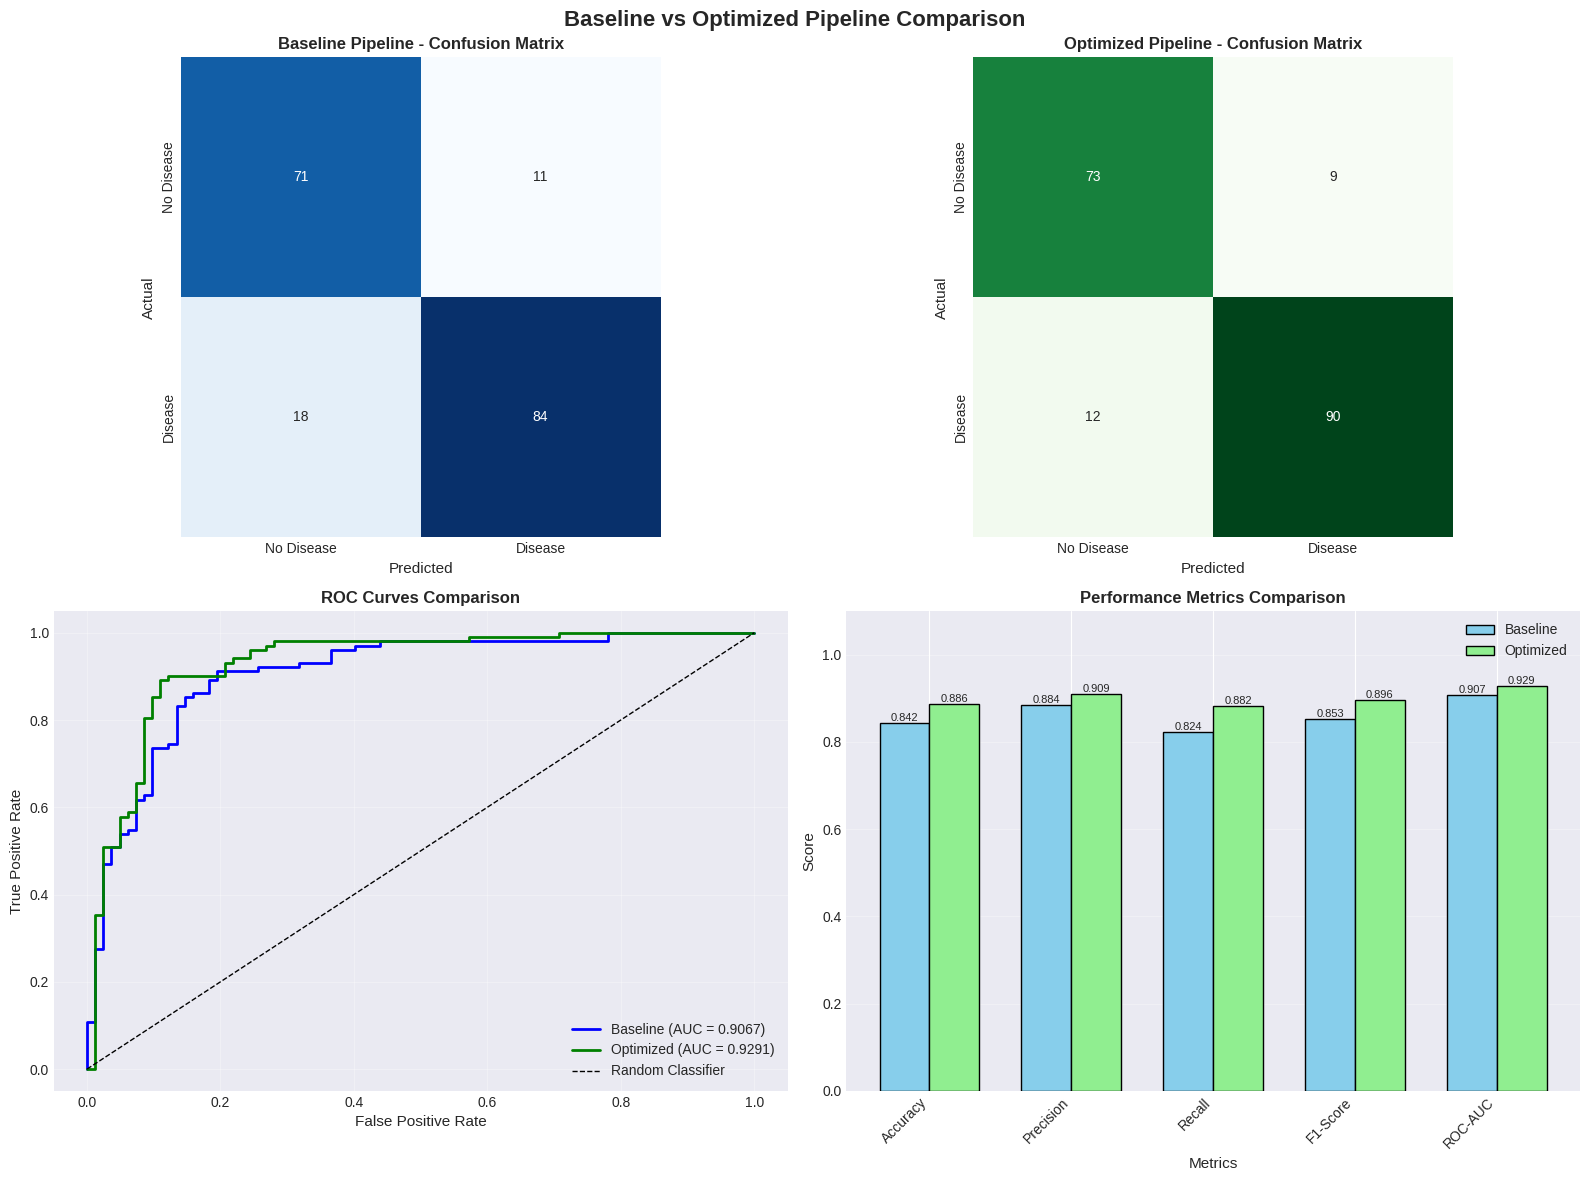

In [143]:
# Make predictions with optimized pipeline
y_pred_optimized = optimized_pipeline.predict(X_test_eng)
y_pred_proba_optimized = optimized_pipeline.predict_proba(X_test_eng)[:, 1]

print("="*80)
print("Optimized Pipeline Performance")
print("="*80)

# Calculate metrics
accuracy_opt = accuracy_score(y_test, y_pred_optimized)
precision_opt = precision_score(y_test, y_pred_optimized)
recall_opt = recall_score(y_test, y_pred_optimized)
f1_opt = f1_score(y_test, y_pred_optimized)
roc_auc_opt = roc_auc_score(y_test, y_pred_proba_optimized)
mcc_opt = matthews_corrcoef(y_test, y_pred_optimized)

print(f"\n{'Metric':<20} {'Score':<10}")
print("-"*30)
print(f"{'Accuracy':<20} {accuracy_opt:.4f}")
print(f"{'Precision':<20} {precision_opt:.4f}")
print(f"{'Recall':<20} {recall_opt:.4f}")
print(f"{'F1-Score':<20} {f1_opt:.4f}")
print(f"{'ROC-AUC':<20} {roc_auc_opt:.4f}")
print(f"{'Matthews Corr Coef':<20} {mcc_opt:.4f}")

# Classification Report
print("\n" + "-"*80)
print("Classification Report")
print("-"*80)
print(classification_report(y_test, y_pred_optimized, target_names=['No Disease', 'Disease']))

# Confusion Matrix
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
print("\n" + "-"*80)
print("Confusion Matrix")
print("-"*80)
print(cm_optimized)

# Model Comparison
print("\n" + "="*80)
print("Baseline vs Optimized Pipeline Comparison")
print("="*80)

comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'MCC'],
    'Baseline': [accuracy, precision, recall, f1, roc_auc, mcc],
    'Optimized': [accuracy_opt, precision_opt, recall_opt, f1_opt, roc_auc_opt, mcc_opt],
    'Improvement': [
        accuracy_opt - accuracy,
        precision_opt - precision,
        recall_opt - recall,
        f1_opt - f1,
        roc_auc_opt - roc_auc,
        mcc_opt - mcc
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Improvement %'] = (comparison_df['Improvement'] / comparison_df['Baseline'] * 100).round(2)
print("\n", comparison_df.to_string(index=False))

# Visualization: Side-by-side comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Baseline vs Optimized Pipeline Comparison', fontsize=16, fontweight='bold')

# 1. Confusion Matrices
ax1 = axes[0, 0]
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'],
            cbar=False, ax=ax1)
ax1.set_ylabel('Actual', fontsize=11)
ax1.set_xlabel('Predicted', fontsize=11)
ax1.set_title('Baseline Pipeline - Confusion Matrix', fontsize=12, fontweight='bold')

ax2 = axes[0, 1]
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Greens', square=True,
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'],
            cbar=False, ax=ax2)
ax2.set_ylabel('Actual', fontsize=11)
ax2.set_xlabel('Predicted', fontsize=11)
ax2.set_title('Optimized Pipeline - Confusion Matrix', fontsize=12, fontweight='bold')

# 2. ROC Curves
ax3 = axes[1, 0]
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba_baseline)
fpr_opt, tpr_opt, _ = roc_curve(y_test, y_pred_proba_optimized)

ax3.plot(fpr_base, tpr_base, label=f'Baseline (AUC = {roc_auc:.4f})', linewidth=2, color='blue')
ax3.plot(fpr_opt, tpr_opt, label=f'Optimized (AUC = {roc_auc_opt:.4f})', linewidth=2, color='green')
ax3.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax3.set_xlabel('False Positive Rate', fontsize=11)
ax3.set_ylabel('True Positive Rate', fontsize=11)
ax3.set_title('ROC Curves Comparison', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)

# 3. Metrics Comparison Bar Chart
ax4 = axes[1, 1]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
baseline_scores = [accuracy, precision, recall, f1, roc_auc]
optimized_scores = [accuracy_opt, precision_opt, recall_opt, f1_opt, roc_auc_opt]

x = np.arange(len(metrics))
width = 0.35
bars1 = ax4.bar(x - width/2, baseline_scores, width, label='Baseline', color='skyblue', edgecolor='black')
bars2 = ax4.bar(x + width/2, optimized_scores, width, label='Optimized', color='lightgreen', edgecolor='black')

ax4.set_xlabel('Metrics', fontsize=11)
ax4.set_ylabel('Score', fontsize=11)
ax4.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics, rotation=45, ha='right')
ax4.legend()
ax4.set_ylim([0, 1.1])
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


## 11. Feature Importance Analysis (From Pipeline)

Extract feature importance from the trained pipeline's classifier component.

**Challenge with Pipelines:**
- Feature names change after preprocessing (one-hot encoding creates new features)
- Need to map transformed feature names back to original features

**Solution:**
- Access the classifier: `pipeline.named_steps['classifier']`
- Get transformed feature names from preprocessor
- Match importance scores to feature names

LightGBM provides feature importance based on:
- **split**: Number of times feature is used in a split
- **gain**: Total information gain when splitting on the feature (default)

Feature Importance Analysis

 Transformed Features: 27 total
  - Binary categorical: 2
  - One-hot encoded: 14
  - Numerical: 11

--------------------------------------------------------------------------------
All Feature Importances (Optimized Model)
--------------------------------------------------------------------------------
                  Feature  Importance
     age_chol_interaction         199
                RestingBP         158
  oldpeak_age_interaction         140
            hr_percentage         134
              Cholesterol         134
                  Oldpeak         124
                    MaxHR         123
                      Age         102
               hr_reserve          74
                      Sex          60
              ST_Slope_Up          56
               hr_deficit          54
pain_exercise_combo_ASY_Y          39
            ST_Slope_Flat          37
                FastingBS          35
        ChestPainType_NAP          31
        RestingECG_N

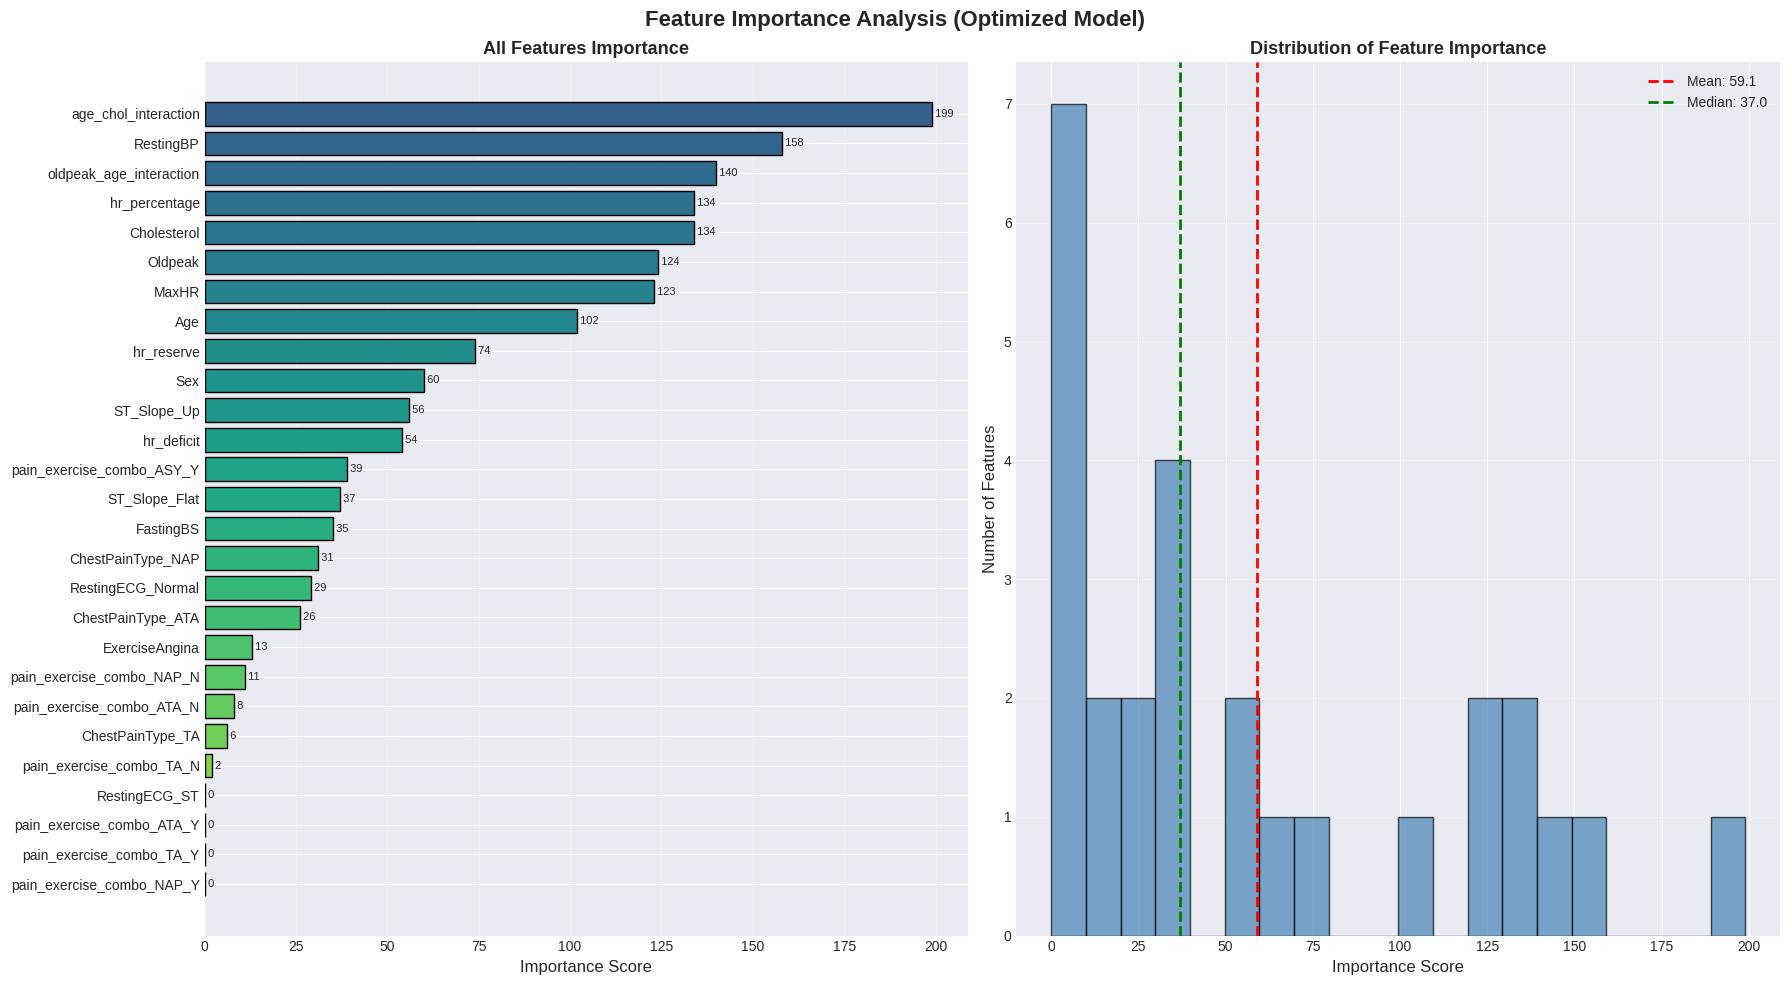

In [144]:
print("="*80)
print("Feature Importance Analysis")
print("="*80)

# Extract the classifier from the pipeline
lgb_classifier = optimized_pipeline.named_steps['classifier']

# Get feature names after preprocessing
# This requires getting the transformed feature names from the ColumnTransformer
preprocessor_fitted = optimized_pipeline.named_steps['preprocessor']

# Build feature names from the ColumnTransformer (with engineered features)
feature_names = []

# Binary categorical features (label encoded) - keep original names
feature_names.extend(binary_categorical_eng)

# Multi-categorical features (one-hot encoded) - get new names
onehot_encoder = preprocessor_fitted.named_transformers_['multi_cat'].named_steps['onehot']
onehot_feature_names = onehot_encoder.get_feature_names_out(multi_categorical_eng)
feature_names.extend(onehot_feature_names)

# Numerical features - keep original names
feature_names.extend(numerical_features_eng)

print(f"\n Transformed Features: {len(feature_names)} total")
print(f"  - Binary categorical: {len(binary_categorical_eng)}")
print(f"  - One-hot encoded: {len(onehot_feature_names)}")
print(f"  - Numerical: {len(numerical_features_eng)}")

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': lgb_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "-"*80)
print("All Feature Importances (Optimized Model)")
print("-"*80)
print(feature_importance.to_string(index=False))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(18, max(10, len(feature_importance) * 0.3)))
fig.suptitle('Feature Importance Analysis (Optimized Model)', fontsize=16, fontweight='bold')

# All features - horizontal bar chart
ax1 = axes[0]
colors_gradient = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance)))
ax1.barh(range(len(feature_importance)), feature_importance['Importance'], color=colors_gradient, edgecolor='black')
ax1.set_yticks(range(len(feature_importance)))
ax1.set_yticklabels(feature_importance['Feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Importance Score', fontsize=12)
ax1.set_title('All Features Importance', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(feature_importance.iterrows()):
    ax1.text(row['Importance'], i, f' {row["Importance"]:.0f}', 
             va='center', fontsize=8)

# Feature importance distribution
ax2 = axes[1]
ax2.hist(feature_importance['Importance'], bins=20, color='steelblue', 
         alpha=0.7, edgecolor='black')
ax2.set_xlabel('Importance Score', fontsize=12)
ax2.set_ylabel('Number of Features', fontsize=12)
ax2.set_title('Distribution of Feature Importance', fontsize=13, fontweight='bold')
ax2.axvline(feature_importance['Importance'].mean(), color='red', 
            linestyle='--', linewidth=2, label=f'Mean: {feature_importance["Importance"].mean():.1f}')
ax2.axvline(feature_importance['Importance'].median(), color='green', 
            linestyle='--', linewidth=2, label=f'Median: {feature_importance["Importance"].median():.1f}')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 12. Model Interpretation & Predictions (Using Pipeline)

Demonstrate how to use the trained pipeline for making predictions on new data.

**Pipeline Advantages for Predictions:**
- Pass raw, unprocessed data directly to pipeline
- Pipeline handles all preprocessing automatically
- Consistent transformations guaranteed
- Single `.predict()` call handles everything

Model Predictions - Sample Cases
Prediction Examples

Sample 1 (Index: 449)

Patient Information (Raw Input):
  Age: 55 years
  Sex: M
  Chest Pain Type: NAP
  Resting BP: 0 mm Hg
  Cholesterol: 0 mg/dl
  Fasting Blood Sugar > 120: No
  Resting ECG: Normal
  Max Heart Rate: 155 bpm
  Exercise Angina: N
  Oldpeak: 1.5
  ST Slope: Flat

Pipeline Prediction:
  Actual: Heart Disease
  Predicted: No Heart Disease
  Confidence (No Disease): 59.13%
  Confidence (Disease): 40.87%
  Status: INCORRECT

Sample 2 (Index: 428)

Patient Information (Raw Input):
  Age: 62 years
  Sex: M
  Chest Pain Type: ASY
  Resting BP: 110 mm Hg
  Cholesterol: 0 mg/dl
  Fasting Blood Sugar > 120: No
  Resting ECG: Normal
  Max Heart Rate: 120 bpm
  Exercise Angina: Y
  Oldpeak: 0.5
  ST Slope: Flat

Pipeline Prediction:
  Actual: Heart Disease
  Predicted: Heart Disease
  Confidence (No Disease): 7.14%
  Confidence (Disease): 92.86%
  Status: CORRECT

Sample 3 (Index: 638)

Patient Information (Raw Input):
  Age:

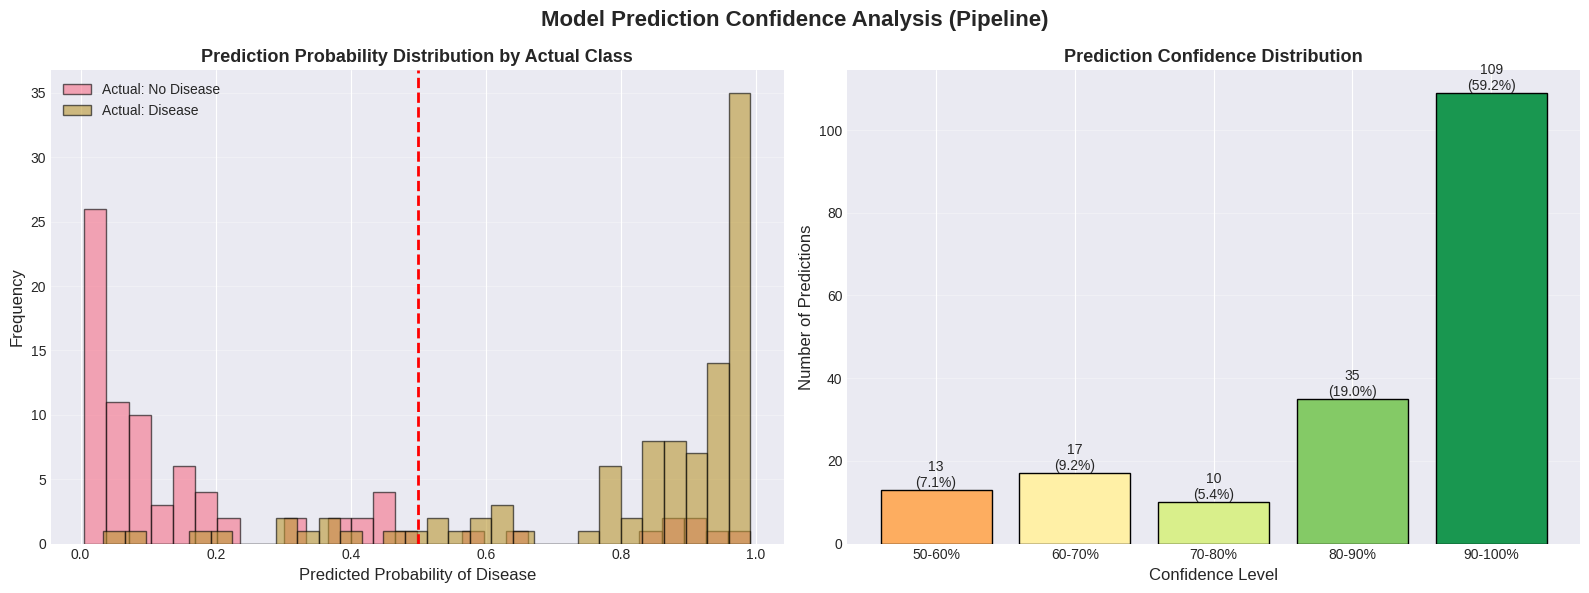

In [145]:
print("Model Predictions - Sample Cases")


# Select random samples from test set (using ORIGINAL unprocessed data)
np.random.seed(42)
sample_indices = np.random.choice(X_test.index, size=5, replace=False)
sample_data_raw = X_test_eng.loc[sample_indices]  # Engineered data
sample_actual = y_test.loc[sample_indices]

# Make predictions using the PIPELINE (handles preprocessing automatically)
sample_predictions = optimized_pipeline.predict(sample_data_raw)
sample_probabilities = optimized_pipeline.predict_proba(sample_data_raw)

print("Prediction Examples")

for i, idx in enumerate(sample_indices):
    print(f"\n{'='*80}")
    print(f"Sample {i+1} (Index: {idx})")
    print(f"{'='*80}")
    
    # Get original data
    original_row = df.loc[idx]
    
    print("\nPatient Information (Raw Input):")
    print(f"  Age: {original_row['Age']} years")
    print(f"  Sex: {original_row['Sex']}")
    print(f"  Chest Pain Type: {original_row['ChestPainType']}")
    print(f"  Resting BP: {original_row['RestingBP']} mm Hg")
    print(f"  Cholesterol: {original_row['Cholesterol']} mg/dl")
    print(f"  Fasting Blood Sugar > 120: {'Yes' if original_row['FastingBS'] else 'No'}")
    print(f"  Resting ECG: {original_row['RestingECG']}")
    print(f"  Max Heart Rate: {original_row['MaxHR']} bpm")
    print(f"  Exercise Angina: {original_row['ExerciseAngina']}")
    print(f"  Oldpeak: {original_row['Oldpeak']}")
    print(f"  ST Slope: {original_row['ST_Slope']}")
    
    print(f"\nPipeline Prediction:")
    print(f"  Actual: {'Heart Disease' if sample_actual.iloc[i] else 'No Heart Disease'}")
    print(f"  Predicted: {'Heart Disease' if sample_predictions[i] else 'No Heart Disease'}")
    print(f"  Confidence (No Disease): {sample_probabilities[i][0]:.2%}")
    print(f"  Confidence (Disease): {sample_probabilities[i][1]:.2%}")
    print(f"  Status: {'CORRECT' if sample_predictions[i] == sample_actual.iloc[i] else 'INCORRECT'}")

# Probability distribution visualization

print("Prediction Confidence Distribution")

# Get all test predictions using pipeline (with engineered features)
all_proba = optimized_pipeline.predict_proba(X_test_eng)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Prediction Confidence Analysis (Pipeline)', fontsize=16, fontweight='bold')

# Probability distribution by actual class
ax1 = axes[0]
for label in [0, 1]:
    mask = y_test == label
    proba_subset = all_proba[mask]
    ax1.hist(proba_subset, bins=30, alpha=0.6, 
             label=f'Actual: {"Disease" if label else "No Disease"}',
             edgecolor='black')
ax1.set_xlabel('Predicted Probability of Disease', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Prediction Probability Distribution by Actual Class', fontsize=13, fontweight='bold')
ax1.legend()
ax1.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
ax1.grid(True, alpha=0.3, axis='y')

# Confidence levels
ax2 = axes[1]
confidence = np.maximum(all_proba, 1 - all_proba)
confidence_bins = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
confidence_labels = ['50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
confidence_counts = [np.sum((confidence >= confidence_bins[i]) & (confidence < confidence_bins[i+1])) 
                     for i in range(len(confidence_bins)-1)]

colors_conf = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(confidence_labels)))
bars = ax2.bar(confidence_labels, confidence_counts, color=colors_conf, edgecolor='black')
ax2.set_xlabel('Confidence Level', fontsize=12)
ax2.set_ylabel('Number of Predictions', fontsize=12)
ax2.set_title('Prediction Confidence Distribution', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({height/len(all_proba)*100:.1f}%)',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
